In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [28]:
df = pd.read_csv("./data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [29]:
df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


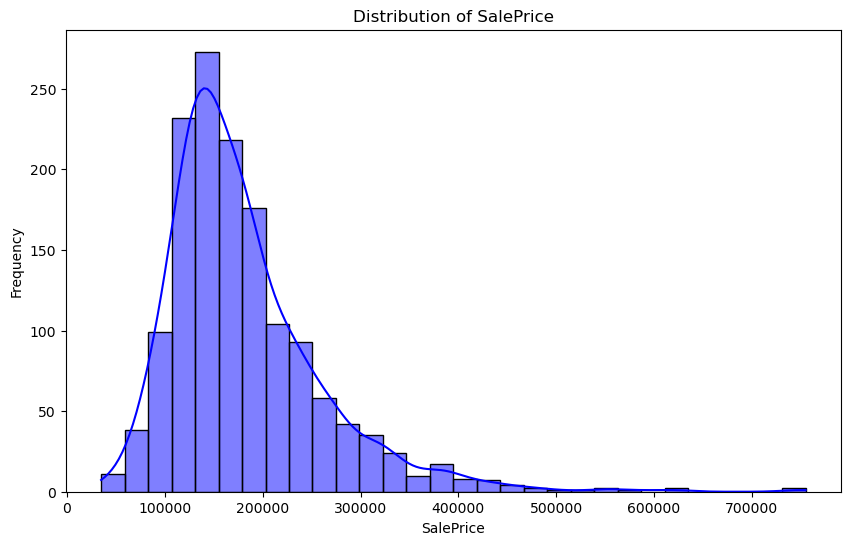

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

In [30]:
numeric_features = df.select_dtypes(include = ['number']).columns
variance = df[numeric_features].var()
low_variance_features = variance[variance < 0.01].index
print('Low variance features: ', low_variance_features)

Low variance features:  Index([], dtype='object')


In [31]:
categorical_features = df.select_dtypes(include = ['object']).columns
unique_categories = df[categorical_features].nunique()
print('Features categories: ', unique_categories)

Features categories:  MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64


In [41]:
df = pd.get_dummies(df, drop_first=True)
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBathrooms'] = df['FullBath'] + 0.5 * df['HalfBath']
df['Interaction_OvQual_GrLivArea'] = df['OverallQual'] * df['GrLivArea']

exter_qual_columns = [col for col in df.columns if 'ExterQual' in col]
bsmt_qual_columns = [col for col in df.columns if 'BsmtQual' in col]

print("ExterQual columns:", exter_qual_columns)
print("BsmtQual columns:", bsmt_qual_columns)

df['QualityIndex'] = df[exter_qual_columns + bsmt_qual_columns].sum(axis=1)
df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']


ExterQual columns: ['ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA']
BsmtQual columns: ['BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA']


In [42]:
X = df.drop('SalePrice', axis = 1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = XGBRegressor()

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 2],
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
)
    
random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

y_pred = random_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.9}
Mean Squared Error: 690934411.5994518


In [43]:
y.mean()
# Given values
rmse = mse ** 0.5
mean_saleprice = y.mean()

# Calculate relative error
relative_error = rmse / mean_saleprice

print("Relative Error:", relative_error)

Relative Error: 0.14528773782997345
